<a href="https://colab.research.google.com/github/dhimasady/BDPAL/blob/main/23_21_1573_UAS_BDPAL_Anime_Recomendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# spark.stop()
# spark = SparkSession.builder.appName("AnimeListData").getOrCreate()

In [ ]:
!pip install pyspark

# NOMOR 1

In [ ]:
from pyspark.sql import SparkSession, Row
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import when, col, rand
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
from pyspark.sql.types import DoubleType, StructType, StructField, StringType
from pyspark.ml.classification import ProbabilisticClassifier, LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, MultilayerPerceptronClassifier, NaiveBayes, GBTClassifier, LinearSVC

from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator


spark = SparkSession.builder.appName("AnimeListData").getOrCreate()

animelist_df = spark.read.csv("imdb_anime.csv", header=True, inferSchema=True)

In [ ]:
animelist_df.show()

+--------------------+--------------------+-----------+---------------+-------+-----------+--------------------+--------------------+-----------+----------+------+-------+-------------+
|               Title|               Genre|User Rating|Number of Votes|Runtime|       Year|             Summary|               Stars|Certificate| Metascore| Gross|Episode|Episode Title|
+--------------------+--------------------+-----------+---------------+-------+-----------+--------------------+--------------------+-----------+----------+------+-------+-------------+
|           One Piece|Animation, Action...|        8.9|        187,689| 24 min|   (1999– )|"Follows the adve...|Mayumi Tanaka,Lau...|      TV-14|      NULL|187689|      0|         NULL|
|Teenage Mutant Ni...|Animation, Action...|        7.4|         28,895| 99 min|     (2023)|The film follows ...|                NULL|         PG|74        | 28895|      0|         NULL|
|The Super Mario B...|Animation, Advent...|        7.1|        189,108

### Preprocessing Data

In [ ]:
from pyspark.sql.functions import regexp_replace

animelist_df = animelist_df.withColumn("Runtime", regexp_replace(col("Runtime"), " min", ""))
animelist_df.show()

+--------------------+--------------------+-----------+---------------+-------+-----------+--------------------+--------------------+-----------+----------+------+-------+-------------+
|               Title|               Genre|User Rating|Number of Votes|Runtime|       Year|             Summary|               Stars|Certificate| Metascore| Gross|Episode|Episode Title|
+--------------------+--------------------+-----------+---------------+-------+-----------+--------------------+--------------------+-----------+----------+------+-------+-------------+
|           One Piece|Animation, Action...|        8.9|        187,689|     24|   (1999– )|"Follows the adve...|Mayumi Tanaka,Lau...|      TV-14|      NULL|187689|      0|         NULL|
|Teenage Mutant Ni...|Animation, Action...|        7.4|         28,895|     99|     (2023)|The film follows ...|                NULL|         PG|74        | 28895|      0|         NULL|
|The Super Mario B...|Animation, Advent...|        7.1|        189,108

In [ ]:
# Hilangkan Yang Tidak Perlu
animelist_df = animelist_df.drop("Episode Title", "Metascore")

In [ ]:
animelist_df = animelist_df.withColumn("Number of Votes", animelist_df["User Rating"].cast(DoubleType()))
animelist_df = animelist_df.withColumn("Gross", animelist_df["Gross"].cast(DoubleType()))
animelist_df = animelist_df.withColumn("Runtime", animelist_df["Runtime"].cast(DoubleType()))
animelist_df = animelist_df.withColumn("Episode", animelist_df["Episode"].cast(DoubleType()))

In [ ]:
# Menghitung dan mencetak jumlah nilai null pada setiap kolom

for colname in animelist_df.columns:
    null_count = animelist_df.filter(col(colname).isNull()).count()
    print(f" {colname}: {null_count}")

 Title: 0
 Genre: 0
 User Rating: 20709
 Number of Votes: 20709
 Runtime: 13172
 Year: 126
 Summary: 22170
 Stars: 31452
 Certificate: 16896
 Gross: 21610
 Episode: 746


In [ ]:
# Pengecekan Tipe Data dan Cleansing Null Value
# columns_to_drop_na = ["Runtime", "User Rating", "Gross", "Metascore", "Episode"]
# animelist_clean_df = animelist_df.na.drop(subset=columns_to_drop_na)
animelist_clean_df = animelist_df.na.drop()
animelist_clean_df.printSchema()

root
 |-- Title: string (nullable = true)
 |-- Genre: string (nullable = true)
 |-- User Rating: double (nullable = true)
 |-- Number of Votes: double (nullable = true)
 |-- Runtime: double (nullable = true)
 |-- Year: string (nullable = true)
 |-- Summary: string (nullable = true)
 |-- Stars: string (nullable = true)
 |-- Certificate: string (nullable = true)
 |-- Gross: double (nullable = true)
 |-- Episode: double (nullable = true)



In [ ]:
for colname in animelist_clean_df.columns:
    null_count = animelist_clean_df.filter(col(colname).isNull()).count()
    print(f" {colname}: {null_count}")

 Title: 0
 Genre: 0
 User Rating: 0
 Number of Votes: 0
 Runtime: 0
 Year: 0
 Summary: 0
 Stars: 0
 Certificate: 0
 Gross: 0
 Episode: 0


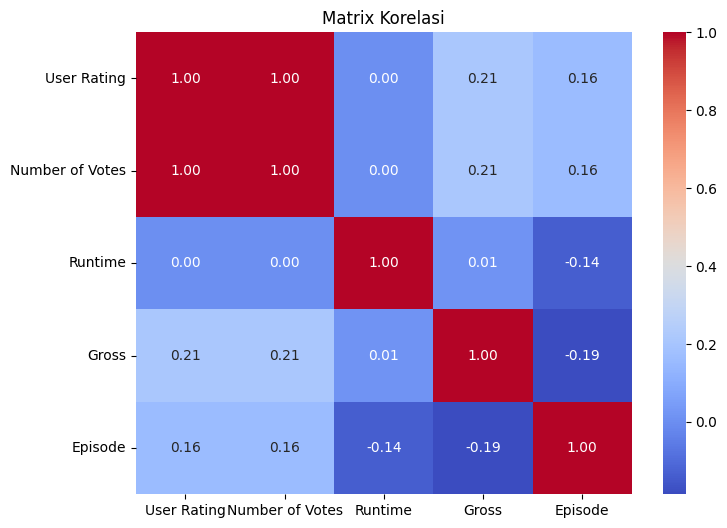

In [ ]:
# Memilih kolom-kolom yang akan dihitung korelasinya
selected_columns = [col_name for col_name, col_type in animelist_clean_df.dtypes if col_type in ['double']]

# Menggabungkan kolom-kolom tersebut menjadi satu vektor kolom
assembler = VectorAssembler(inputCols=selected_columns, outputCol="features")
assembled_df = assembler.transform(animelist_clean_df)

# Menghitung matriks korelasi
correlation_matrix = Correlation.corr(assembled_df, "features").head()

# Mengambil matriks korelasi dari hasil perhitungan
corr_matrix = correlation_matrix[0].toArray()

# Menampilkan matriks korelasi dengan heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", xticklabels=selected_columns, yticklabels=selected_columns)
plt.title("Matrix Korelasi")
plt.show()

### Exploratory Data Analysis (EDA)

In [ ]:
# Menampilkan ringkasan statistik
# Pilih yang bertipe double saja untuk deskripsi statistik
numeric_cols = [col_name for col_name, col_type in animelist_clean_df.dtypes if col_type in ['double']]
eda_data = animelist_clean_df.select(numeric_cols).describe()
eda_data.show()

+-------+------------------+------------------+------------------+------------------+------------------+
|summary|       User Rating|   Number of Votes|           Runtime|             Gross|           Episode|
+-------+------------------+------------------+------------------+------------------+------------------+
|  count|              3707|              3707|              3707|              3707|              3707|
|   mean| 7.324656056110062| 7.324656056110062|29.387375236039926|3754.8702454815216|0.4901537631507958|
| stddev|0.8920084174809487|0.8920084174809487| 41.42275996293413|18364.136437544777|0.4999704827647298|
|    min|               1.5|               1.5|               2.0|               5.0|               0.0|
|    max|               9.9|               9.9|             780.0|          434457.0|               1.0|
+-------+------------------+------------------+------------------+------------------+------------------+



<ipython-input-11-8ce0755d7706>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Gross Range", y="count", data=gross_counts, palette="viridis")


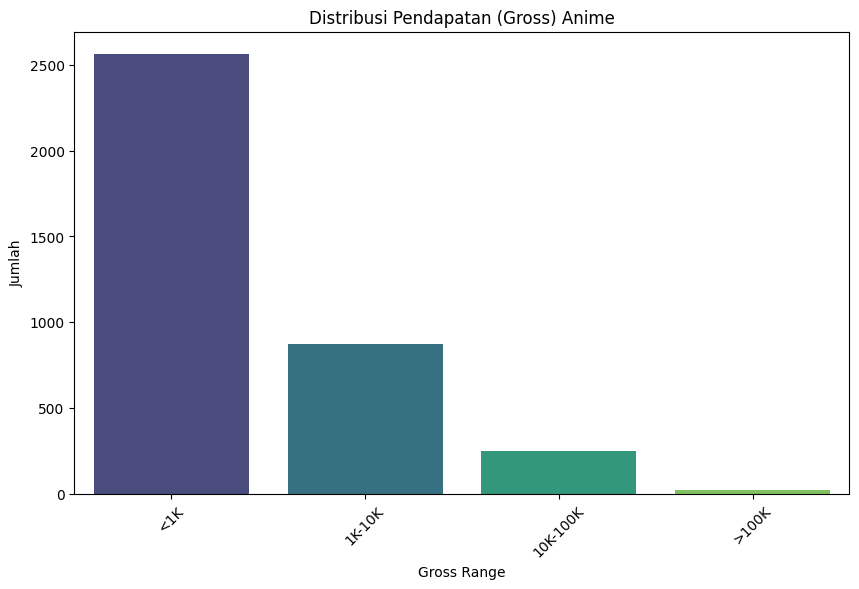

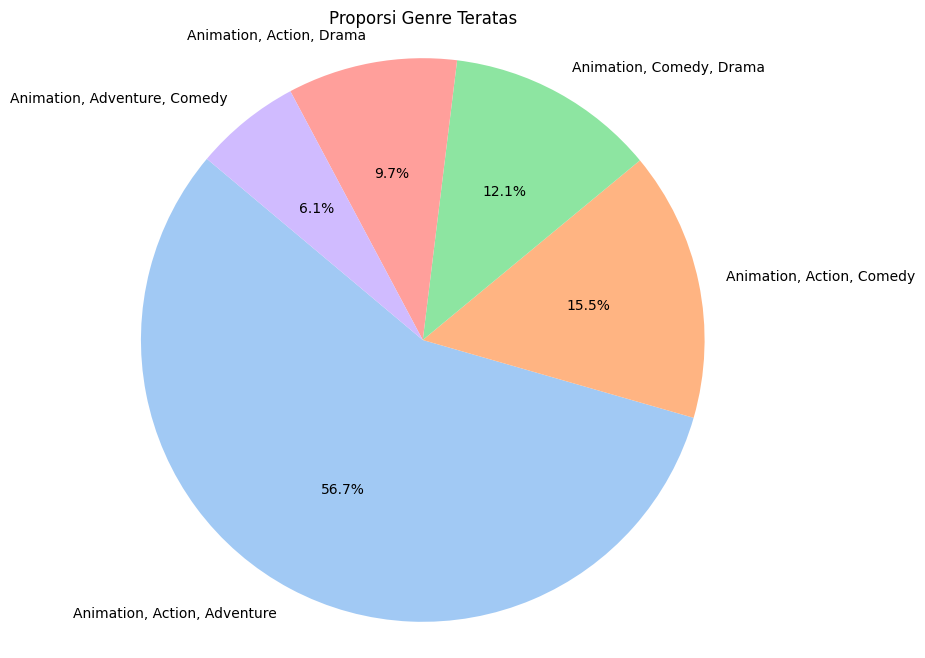

<ipython-input-11-8ce0755d7706>:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=rating_df, x="User Rating", palette="coolwarm")


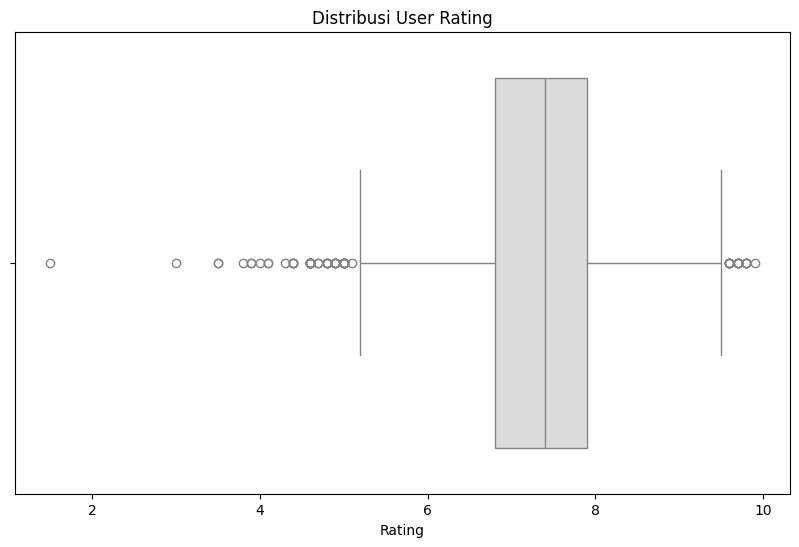

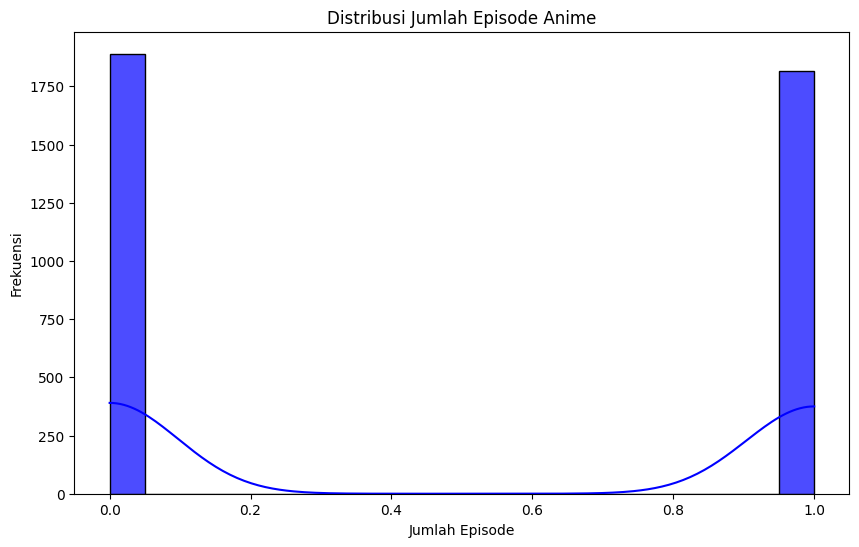

In [ ]:
from pyspark.sql.functions import when, col
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Bar Chart: Distribusi Pendapatan (Gross)
# Membagi pendapatan (Gross) ke dalam rentang kategori
gross_bins = animelist_clean_df.withColumn(
    "Gross Range",
    when(col("Gross") < 1e3, "<1K")
    .when((col("Gross") >= 1e3) & (col("Gross") < 1e4), "1K-10K")
    .when((col("Gross") >= 1e4) & (col("Gross") < 1e5), "10K-100K")
    .when(col("Gross") >= 1e5, ">100K")
    .otherwise("Unknown"),
)

gross_counts = (
    gross_bins.groupBy("Gross Range")
    .count()
    .orderBy(col("count").desc())
    .toPandas()
)

# Visualisasi Bar Chart
plt.figure(figsize=(10, 6))
sns.barplot(x="Gross Range", y="count", data=gross_counts, palette="viridis")
plt.title("Distribusi Pendapatan (Gross) Anime")
plt.xlabel("Gross Range")
plt.ylabel("Jumlah")
plt.xticks(rotation=45)
plt.show()

# 2. Pie Chart: Proporsi Genre Teratas
genre_counts = (
    animelist_clean_df.groupBy("Genre")
    .count()
    .orderBy(col("count").desc())
    .limit(5)  # Mengambil 5 genre teratas
    .toPandas()
)

plt.figure(figsize=(8, 8))
plt.pie(
    genre_counts["count"],
    labels=genre_counts["Genre"],
    autopct="%1.1f%%",
    startangle=140,
    colors=sns.color_palette("pastel"),
)
plt.title("Proporsi Genre Teratas")
plt.axis("equal")
plt.show()

# 3. Box Plot: Distribusi User Rating
rating_df = animelist_clean_df.select("User Rating").toPandas()

plt.figure(figsize=(10, 6))
sns.boxplot(data=rating_df, x="User Rating", palette="coolwarm")
plt.title("Distribusi User Rating")
plt.xlabel("Rating")
plt.show()

# 4. Histogram: Distribusi Jumlah Episode
episode_df = animelist_clean_df.select("Episode").toPandas()

plt.figure(figsize=(10, 6))
sns.histplot(data=episode_df, x="Episode", bins=20, kde=True, color="blue", alpha=0.7)
plt.title("Distribusi Jumlah Episode Anime")
plt.xlabel("Jumlah Episode")
plt.ylabel("Frekuensi")
plt.show()

# NOMOR 2 A

In [ ]:
# Memilih kolom-kolom yang akan dihitung korelasinya
selected_columns = ['User Rating', 'Number of Votes', 'Gross', 'Episode']
indexer = StringIndexer(inputCol="Genre", outputCol="label")

# Ganti nama kolom output VectorAssembler dari "features" menjadi "features_vector"
assembler_vector = VectorAssembler(inputCols=selected_columns, outputCol="features")

# Membuat pipeline dengan kedua tahap transformasi
pipeline = Pipeline(stages=[indexer, assembler_vector])

# Melakukan transformasi pada DataFrame
transformed_df = pipeline.fit(animelist_clean_df).transform(animelist_clean_df)

# Memilih kolom yang diperlukan
selected_df = transformed_df.select("features", "label")

# Split data menjadi training dan testing
train_data, test_data = selected_df.randomSplit([0.8, 0.2], seed=42)

In [ ]:
# Fungsi untuk melatih dan mengevaluasi model
def train_and_evaluate_model(model, train_data, test_data, is_one_vs_rest=False):
  if is_one_vs_rest:
    model = OneVsRest(classifier=model)

  # Membuat pipeline hanya dengan model
  pipeline = Pipeline(stages=[model])
  trained_model = pipeline.fit(train_data)

  # Melakukan prediksi pada data testing
  predictions = trained_model.transform(test_data)

  # Menampilkan metriks evaluasi
  evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
  accuracy = evaluator.evaluate(predictions)
  print(f"Model: {model.__class__.__name__}")
  print(f"Accuracy: {accuracy:.4f}")
  print("-" * 50)

In [ ]:
# Inisialisasi model-machine learning
gb = GBTClassifier(maxIter=5)
nb = NaiveBayes()
rf = RandomForestClassifier()
lr = LinearRegression()

In [ ]:
from pyspark.ml.classification import OneVsRest
train_and_evaluate_model(gb, train_data, test_data, is_one_vs_rest=True)

Model: OneVsRest
Accuracy: 0.4288
--------------------------------------------------


In [ ]:
train_and_evaluate_model(nb, train_data, test_data, is_one_vs_rest=False)

Model: NaiveBayes
Accuracy: 0.0455
--------------------------------------------------


In [ ]:
train_and_evaluate_model(rf , train_data, test_data,is_one_vs_rest=False)

Model: RandomForestClassifier
Accuracy: 0.4626
--------------------------------------------------


In [ ]:
train_and_evaluate_model(lr , train_data, test_data, is_one_vs_rest=False)

Model: LinearRegression
Accuracy: 0.0000
--------------------------------------------------


## NOMOR 2B

In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Fungsi untuk melakukan hyperparameter tuning dan evaluasi model
def tune_and_evaluate_model(model, train_data, test_data, param_grid, is_one_vs_rest=False):

  if is_one_vs_rest:
    model = OneVsRest(classifier=model)

  # Membuat pipeline hanya dengan model
  pipeline = Pipeline(stages=[model])

  # Menggunakan CrossValidator untuk melakukan tuning
  cross_validator = CrossValidator(estimator=pipeline,
                                    estimatorParamMaps=param_grid,
                                    evaluator=MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy"),
                                    numFolds=5)

  # Melatih model pada data training
  tuned_model = cross_validator.fit(train_data)

  # Melakukan prediksi pada data testing
  predictions = tuned_model.transform(test_data)

  # Menampilkan metriks evaluasi
  evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
  accuracy = evaluator.evaluate(predictions)
  print(f"Model: {model.__class__.__name__}")
  print(f"Best Accuracy: {accuracy:.4f}")
  print(f"Best Parameters: {tuned_model.bestModel.stages[0].extractParamMap()}")
  print("-" * 50)

# Inisialisasi model-machine learning
gb = GBTClassifier()
rf = RandomForestClassifier()

# Melakukan hyperparameter tuning untuk Logistic Regression
param_grid_gb = ParamGridBuilder() \
    .addGrid(gb.maxIter, [1, 5]) \
    .addGrid(gb.stepSize, [0.1, 0.05]) \
    .build()

# Melakukan hyperparameter tuning untuk Random Forest
param_grid_rf = ParamGridBuilder() \
    .addGrid(rf.numTrees, [10, 20]) \
    .addGrid(rf.maxDepth, [5, 10,]) \
    .build()

# Melakukan tuning dan evaluasi untuk kedua model
tune_and_evaluate_model(gb, train_data, test_data, param_grid_gb, is_one_vs_rest=True) # Added param_grid_gb to the function call
tune_and_evaluate_model(rf, train_data, test_data, param_grid_rf, is_one_vs_rest=False) # Added param_grid_rf to the function call

Model: OneVsRest
Best Accuracy: 0.4288
Best Parameters: {Param(parent='OneVsRestModel_045e44f123e8', name='predictionCol', doc='prediction column name.'): 'prediction', Param(parent='OneVsRestModel_045e44f123e8', name='featuresCol', doc='features column name.'): 'features', Param(parent='OneVsRestModel_045e44f123e8', name='labelCol', doc='label column name.'): 'label', Param(parent='OneVsRestModel_045e44f123e8', name='rawPredictionCol', doc='raw prediction (a.k.a. confidence) column name.'): 'rawPrediction', Param(parent='OneVsRestModel_045e44f123e8', name='classifier', doc='base binary classifier'): GBTClassifier_72d829fbf24e}
--------------------------------------------------
Model: RandomForestClassifier
Best Accuracy: 0.4684
Best Parameters: {Param(parent='RandomForestClassifier_1c570c14535a', name='bootstrap', doc='Whether bootstrap samples are used when building trees.'): True, Param(parent='RandomForestClassifier_1c570c14535a', name='cacheNodeIds', doc='If false, the algorithm w